In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import keras
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers as kl
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as cb
import sklearn.metrics as skmetrics



os.chdir(os.getcwd().replace("/notebooks", "") if os.getcwd().startswith("/Users") else "/content/drive/MyDrive/Colab Notebooks/image_duplicate")

from src.models.euclidian_distance import euclidian_distance
from src.data.dataset import loader as dataset_loader

from src.visualisations.image_plot import plot_n
from src.data.dataset.image_shape import ImageShape
from src.data.utility.tf_data_transformer import TfDatasetTransformer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [2]:
MODEL_NAME = "model_1"

DATASET_LOADER = dataset_loader
IMAGE_SHAPE = ImageShape(height=224, width=224, depth=3)
MODEL_OUTPUT_PATH = f"./output/{MODEL_NAME}"

BATCH_SIZE = 64

# Data Loading

In [12]:
train_dataset = DATASET_LOADER.load_train_v1()
val_dataset = DATASET_LOADER.load_validation_v1()

In [13]:
pair_tuples = list(map(lambda pair: (pair.image_a, pair.image_b, pair.similar), train_dataset.image_pairs))
pair_array = np.array(pair_tuples)


tf_dataset_transformer =  TfDatasetTransformer(image_shape=IMAGE_SHAPE)

train_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(train_dataset, shuffle=True, shuffle_buffer_size=1024)\
                                         .cache()\
                                         .batch(BATCH_SIZE)\
                                         .prefetch(AUTOTUNE)

val_tf_dataset = tf_dataset_transformer.transform_to_tf_dataset(val_dataset)\
                                         .cache()\
                                         .batch(128)\
                                         .prefetch(AUTOTUNE)


In [9]:
v = next(train_tf_dataset.as_numpy_iterator())[0][0][0]
v

2022-03-01 20:03:30.991536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

# Model

In [5]:
def create_common_model() -> keras.Model:
    input = keras.Input(shape=IMAGE_SHAPE.to_shape())
    x = kl.Conv2D(filters=64, kernel_size=7, strides=2, padding="valid", activation="relu")(input)
    x = kl.BatchNormalization()(x)
    x = kl.MaxPool2D(pool_size=3)(x)
    x = kl.Flatten()(x)
    return keras.Model(inputs=input, outputs=x)

def create_model() -> keras.Model:
    input_a = keras.Input(shape=IMAGE_SHAPE.to_shape())
    input_b = keras.Input(shape=IMAGE_SHAPE.to_shape())

    common_model = create_common_model()

    layer_a = common_model(input_a)
    layer_b = common_model(input_b)

    merge_layer = kl.Lambda(euclidian_distance)([layer_a, layer_b])
    merge_layer = kl.Dropout(0.25)(merge_layer)
    merge_layer = kl.Dense(128, activation="relu")(merge_layer)
    merge_layer = kl.Dropout(0.25)(merge_layer)
    merge_layer = kl.Dense(1, activation="sigmoid")(merge_layer)

    return keras.Model(inputs=[input_a, input_b], outputs=merge_layer)



model = create_model()
model.compile(
    optimizer=optimizers.Adam(), loss=losses.CategoricalHinge(), metrics="accuracy")

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 82944)        9728        ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

Epoch 1/3
5/5 [==============================] - ETA: 0s - loss: 0.9050 - accuracy: 0.4875

2022-03-02 22:12:40.405008: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./output/model_1/model1/assets
5/5 [==============================] - 148s 36s/step - loss: 0.9050 - accuracy: 0.4875 - val_loss: 0.8724 - val_accuracy: 0.7159
Epoch 2/3
5/5 [==============================] - 54s 13s/step - loss: 0.8817 - accuracy: 0.5063 - val_loss: 0.8842 - val_accuracy: 0.7179
Epoch 3/3
5/5 [==============================] - 53s 13s/step - loss: 0.8510 - accuracy: 0.5125 - val_loss: 0.9032 - val_accuracy: 0.7221


2022-03-02 22:14:28.290938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<AxesSubplot:>

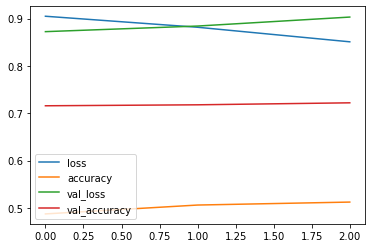

In [6]:
save_cb = cb.ModelCheckpoint(MODEL_OUTPUT_PATH, save_best_only=True)

history = model.fit(train_tf_dataset, epochs=3, workers=8, max_queue_size=20, steps_per_epoch=5, validation_data=val_tf_dataset, callbacks=[save_cb])

pd.DataFrame(history.history).plot()

In [17]:
import gc
gc.collect(2)#%%

6296

# Evaluation

In [10]:
model: keras.Model = keras.models.load_model(MODEL_OUTPUT_PATH)
predictions = model.predict(val_tf_dataset, workers=8, verbose=1)


84/84 [==============================] - 48s 571ms/step


In [17]:
print(skmetrics.classification_report(val_dataset.similarities(), predictions > 0.5))

              precision    recall  f1-score   support

       False       0.62      1.00      0.77      4987
        True       1.00      0.47      0.64      5737

    accuracy                           0.72     10724
   macro avg       0.81      0.73      0.70     10724
weighted avg       0.82      0.72      0.70     10724

